In [1]:
%matplotlib inline

import xarray as xr
import datetime
import os
import matplotlib.pyplot as plt
from dask.dot import dot_graph
import itertools
import logging
import netCDF4
import numpy as np
import numpy.ma as ma
import dask.array as da
from dask import delayed
import time
from dask.distributed import Client
from urllib import request
from multiprocessing import Pool
import glob

client = Client('scheduler:8786')

download_location = '/temp'
# data_url = 'http://nasanex.s3.amazonaws.com'
data_url = 'http://172.21.0.1:8080'
max_download_attempts = 5

all_models = ['ACCESS1-0',  'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC-ESM-CHEM', 'MIROC-ESM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M', 'bcc-csm1-1', 'inmcm4']
# all_models = ['ACCESS1-0', 'BNU-ESM'] 
all_vars = ['tasmax', 'pr']
all_years = {
     # 'historical': list(range(1971, 1976))
    'historical': list(range(1971, 2001))
}

year_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year_leap_days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

def get_dataset_url(variable, scenario, model, year, prefix = data_url):
    prefix_filename = '/'.join([prefix, 'NEX-GDDP', 'BCSD', scenario, 'day', 'atmos', variable, 'r1i1p1', 'v1.0'])
    filename = '_'.join([variable, 'day', 'BCSD', scenario, 'r1i1p1', model, str(year) + '.nc'])
    url = '/'.join([prefix_filename, filename])
    # url = '/'.join([prefix, filename])
    return url

def get_context(year, **kwargs):
    variables = [kwargs.get('variable')] if kwargs.get('variable') else all_vars
    scenarios = ['historical']
    models = [kwargs.get('model')] if kwargs.get('model') else all_models
    outlist = []
    combinations = list(itertools.product(variables, scenarios, models))
    result = list(map(lambda comb: [ *comb, year ], combinations))
    return result

def get_year_ensemble(year, variable = 'tasmax'):
    context = get_context(year, variable = variable)
    datasets = list(map(lambda x: str(get_dataset_url(*x)), context))
    return datasets

def download_file(url):
    print("url: " + url)
    attempts = 0
    success = False
    filename = ""
    while attempts < max_download_attempts and not success:
        time.sleep(2 ** attempts)
        filename = '/'.join([download_location, str(url.split('/')[-1])])
        print("Downloading file at " + filename)
        u = request.urlopen(url)
        f = open(filename, 'wb')
        f.write(u.read())
        f.close()
        success = True
        break
    return filename

def download_file_list(url_list):
    print("Starting download pool")
    pool = Pool()
    res = pool.map(download_file, url_list)
    print("Jobs sent")
    pool.close()
    pool.join()
    print("Downloads finished")
    print(res)
    return res

def download_and_stack(year, variable):
    dsets_urls = list(map(lambda x: get_year_ensemble(x, variable = variable), [year]))[0]
    filenames = download_file_list(dsets_urls)
    datasets = [ netCDF4.Dataset(filename) for filename in filenames ]
    dask_arrays = []
    for dset in datasets:
        dask_arrays.append(da.from_array(dset[str(variable)], chunks= (366, 144, 144)))
    try:
        final_stack = da.stack(dask_arrays, axis = 0)
    except:
        return filenames, None, None
    return filenames, datasets, final_stack

def destack(a, chunksize):
    nmodels, tasvars, time, lat, lon = a.shape
    nstacks_lat = int(np.ceil(lat / chunksize))
    nstacks_lon = int(np.ceil(lon / chunksize))
    
    stacks = []
    
    for i in range(nstacks_lat):
        for j in range(nstacks_lon):
            latmin, latmax = i * chunksize, (i+1) * chunksize
            lonmin, lonmax = j * chunksize, (j+1) * chunksize
            # print(i, j, '~>', latmin, latmax, lonmin, lonmax)
            stacked = a[:, :, :, latmin:latmax, lonmin:lonmax]
            # print(stacked)
            stacks.append(stacked)
    return stacks

def copy_dataset(src, output_filename):
    dst = netCDF4.Dataset('/home/jovyan/work/' + output_filename, "w")
    # copy attributes
    for name in src.ncattrs():
        dst.setncattr(name, src.getncattr(name))
    # copy dimensions
    for name, dimension in src.dimensions.items():
        dst.createDimension(
            name, (dimension)
        )
    dst.close()
    return output_filename

def restack(chunk_list, chunksize):
    shapes = list(map(np.shape, chunk_list))
    ndays = shapes[0][0]
    nlons = int(1440 / chunksize)
    nlats = int(720 / chunksize)
    out_array = np.empty((ndays, 720, 1440))
    combs = list(itertools.product(
        list(range(nlats)),
        list(range(nlons))
    ))
    res_list = zip(combs, chunk_list)
    for position, arr in res_list:
        minlon, maxlon = position[0] * chunksize, position[0] * chunksize + chunksize
        minlat, maxlat = position[1] * chunksize, position[1] * chunksize + chunksize
        out_array[:, minlon:maxlon, minlat:maxlat] = arr
    return out_array

def stack_from_disk(year, chunksize):
    year_ensemble_tasmin = list(map(lambda x: x.split('/')[-1], get_year_ensemble(year, variable = 'tasmin')))
    year_ensemble_tasmax = list(map(lambda x: x.split('/')[-1], get_year_ensemble(year, variable = 'tasmax')))
    datasets_tasmin = [ netCDF4.Dataset('../temp/' + filename) for filename in year_ensemble_tasmin ]
    datasets_tasmax = [ netCDF4.Dataset('../temp/' + filename) for filename in year_ensemble_tasmax ]
    das_tasmin = list(map(lambda dset: da.from_array(dset['tasmin'], chunks = (365, chunksize, chunksize)), datasets_tasmin))
    das_tasmax = list(map(lambda dset: da.from_array(dset['tasmax'], chunks = (365, chunksize, chunksize)), datasets_tasmax))
    # da.stack(list(map(lambda dset: da.from_array(dset['tasmax'], chunks = (365, 144, 144)), datasets_tasmax)))
    final_stack = da.stack([da.stack(tup) for tup in list(zip(das_tasmin, das_tasmax))])
    return final_stack

def days_to_ranges(years):
    ranges = [year_days[:i +1] for i, n in enumerate(year_days)]
    result = [(sum(element[:-1]), sum(element)) for element in ranges]
    return result

def stack_to_months(stack):
    days = days_to_ranges(year_days) if stack.shape[2] == 365 else days_to_ranges(year_leap_days)
    for period in days:
        yield(stack[:, :, period[0]:period[1], :, :])

def stack_to_models(stack):
    for model in range(stack.shape[0]):
        yield(stack[model, :, :, :])


In [71]:
# Ensure we have a clean client for testing
client.restart()

<Client: scheduler='tcp://172.21.0.4:8786' processes=1 cores=4>

In [3]:
year = 1971

print(f"Starting processing for year {str(year)}")
print(datetime.datetime.now())
print("Downloading")

# Stacking all data into the same dask dataset
# Change for download from amazon
stack_year = stack_from_disk(year, 144)
# Geographic chunking
print(stack_year)
# dask.array<stack, shape=(21, 2, 365, 720, 1440), dtype=float32, chunksize=(1, 1, 365, 360, 360)>
# tasavg = np.mean(stack_year, axis = 1)
# Can't really calc this without flooding memory

Starting processing for year 1971
2017-11-28 17:50:29.749846
Downloading


dask.array<stack, shape=(21, 2, 365, 720, 1440), dtype=float32, chunksize=(1, 1, 365, 144, 144)>


In [4]:
# Yearly indexes:
tasmax_stack = stack_year[:, 0, :, :, :]
tasmin_stack = stack_year[:, 1, :, :, :]

print(tasmax_stack)
print(tasmin_stack)

tasavg_stack = (tasmax_stack + tasmin_stack) / 2
print(tasavg_stack)

tasmin_per_model = list(stack_to_models(tasmin_stack))
tasmax_per_model = list(stack_to_models(tasmax_stack))
tasavg_per_model = list(stack_to_models(tasavg_stack))
print(tasavg_per_model)


dask.array<getitem, shape=(21, 365, 720, 1440), dtype=float32, chunksize=(1, 365, 144, 144)>
dask.array<getitem, shape=(21, 365, 720, 1440), dtype=float32, chunksize=(1, 365, 144, 144)>
dask.array<truediv, shape=(21, 365, 720, 1440), dtype=float32, chunksize=(1, 365, 144, 144)>
[dask.array<getitem, shape=(365, 720, 1440), dtype=float32, chunksize=(365, 144, 144)>, dask.array<getitem, shape=(365, 720, 1440), dtype=float32, chunksize=(365, 144, 144)>, dask.array<getitem, shape=(365, 720, 1440), dtype=float32, chunksize=(365, 144, 144)>, dask.array<getitem, shape=(365, 720, 1440), dtype=float32, chunksize=(365, 144, 144)>, dask.array<getitem, shape=(365, 720, 1440), dtype=float32, chunksize=(365, 144, 144)>, dask.array<getitem, shape=(365, 720, 1440), dtype=float32, chunksize=(365, 144, 144)>, dask.array<getitem, shape=(365, 720, 1440), dtype=float32, chunksize=(365, 144, 144)>, dask.array<getitem, shape=(365, 720, 1440), dtype=float32, chunksize=(365, 144, 144)>, dask.array<getitem, shap

In [7]:
test_array_tasavg = tasavg_per_model[0].compute()
test_array_tasmax = tasmax_per_model[0].compute()
test_array_tasmin = tasmin_per_model[0].compute()
print('OK')

In [67]:
baseline = np.load('/temp/baseline_tasmax_99p.npy')
client.scatter(baseline)
def hdd(a, axis):
    a_to_baseline = 291.483 - a
    masked = ma.masked_where(a_to_baseline <= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.sum(intermediate_matrix, axis = 0)
    return result

def cdd(a, axis): # Revise
    a_to_baseline = 291.483 - a
    a_to_baseline[a_to_baseline < -10000] = 0
    masked = ma.masked_where(a_to_baseline >= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.sum(np.abs(intermediate_matrix), axis = 0)
    return result
    
def extreme_heat(a, axis):
    a_to_baseline = a - baseline
    masked = ma.masked_where(a_to_baseline <= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.count_nonzero(intermediate_matrix, axis = axis)
    return result

def longest_streak(diff):
    result = 0
    try:
        result =  np.amax(
            np.array(np.where(diff < 0)) - np.array(np.where(diff > 0))
        )
    except ValueError:
        #raised if empty
        result = 0
    return result
        

def frost_free_season(a, axis):
    # First, dealing with the first matrix
    frost_days_matrix = (a > 273.15) * 1
    # We pad it with zeroes at the ends of the designed axis
    zeros_shape = list(a.shape)
    del zeros_shape[axis]
    zeros_matrix = np.expand_dims(np.zeros(zeros_shape), axis = axis)
    concat_matrix = np.concatenate((zeros_matrix, frost_days_matrix, zeros_matrix))
    # We calculate the deltas along an axis
    diff = np.diff(concat_matrix, axis = axis)
    result = np.apply_along_axis(longest_streak, axis, diff)
    return result

[[ 4  4  4 ...,  4  4  4]
 [ 6  6  6 ..., 10 10  6]
 [10 10  6 ..., 10 10 10]
 ..., 
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  0]]


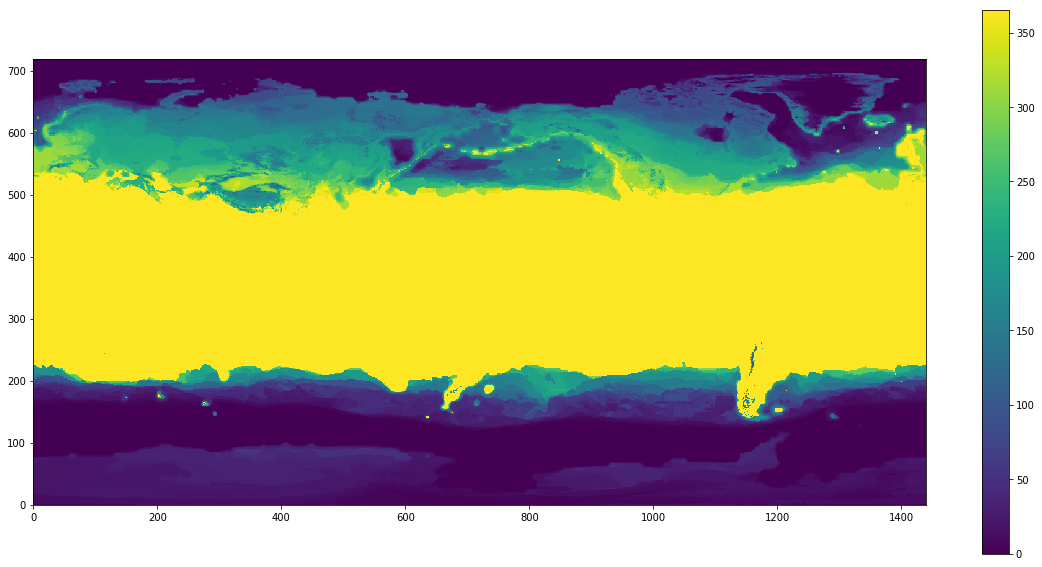

In [73]:
test_ff_result = frost_free_season(test_array_tasmin, axis = 0)
print(test_ff_result)
plt.figure(figsize=(20, 10))
plt.imshow(test_ff_result, origin='lower')
plt.colorbar()

In [ ]:
test_xh_result = extreme_heat(test_array_tasmax, axis = 0)
print(test_xh_result)
plt.figure(figsize=(20, 10))
plt.imshow(test_xh_result, origin='lower')
plt.colorbar()

In [ ]:
test_hdd_result = hdd(test_array_tasavg, axis = 0)
plt.figure(figsize=(20, 10))
plt.imshow(test_hdd_result, origin='lower')
plt.colorbar()

In [ ]:
test_cdd_result = cdd(test_array_tasavg, axis = 0)
plt.figure(figsize=(20, 10))
plt.imshow(test_cdd_result, origin='lower')
plt.colorbar()

In [ ]:
month_stacks = list(stack_to_months(stack_year))
print("Processing monthly information")
for i, month in enumerate(month_stacks):
    print(datetime.datetime.now())

    # Processing temperatures

    # Tasmin
    tasmin_arr = month[:, 0, :, :, :]
    print(f"tasmin_arr.shape: {tasmin_arr.shape}")
    # tasmin_arr.shape: (21, 31, 720, 1440)    

    # In this case this axis corresponds to days
    base_tasmin_mean = np.mean(tasmin_arr, axis = 1)
    # So we first compute an average across days of the month, per model

    # And the mean and percentile per model
    tasmin_avg = np.mean(base_tasmin_mean, axis = 0).compute()
    print(tasmin_avg.shape)
    # (720, 1440)

    np.save('/temp/tasmin_avg_1971.npy', tasmin_avg)
    
    tasmin_p75 = np.percentile(base_tasmin_mean, 75, axis = 0)
    print(tasmin_p75.shape)
    # (720, 1440)

    tasmin_p25 = np.percentile(base_tasmin_mean, 25, axis = 0)
    print(tasmin_p25.shape)
    # (720, 1440)

    np.save('/temp/tasmin_p75_1971.npy', tasmin_p75)
    np.save('/temp/tasmin_p25_1971.npy', tasmin_p25)

    # Tasmax
    # tasmax_arr = month[:, 1, :, :, :]
    # print(f"tasmax_arr.shape: {tasmax_arr.shape}")

    # base_tasmax_mean = np.mean(tasmax_arr, axis = 1)
    # tasmax_avg = np.mean(base_tasmax_mean, axis = 0).compute()
    # print(tasmax_avg.shape)
    # tasmax_p75 = np.percentile(base_tasmax_mean, 75, axis = 0)
    # print(tasmax_avg.shape)
    # tasmax_p25 = np.percentile(base_tasmax_mean, 25, axis = 0)
    # print(tasmax_avg.shape)

    # tasavg_arr = (tasmin_arr + tasmax_arr) / 2
    # print(tasavg_arr)
    # base_tasavg_mean = np.mean(tasavg_arr, axis = 0)
    # print(base_tasavg_mean)
    # tasavg_avg = np.mean(base_tasavg_mean, axis = 0).compute()
    # print(tasavg_avg.shape)
    # tasavg_p75 = np.percentile(base_tasavg_mean, 75, axis = 0)
    # print(tasavg_p75.shape)
    # tasavg_p25 = np.percentile(base_tasavg_mean, 25, axis = 0)
    # print(tasavg_p25.shape)

In [ ]:
hdds_per_model = list(map(lambda arr: delayed(hdd)(arr, axis=0).compute(), tasavg_per_model))
hdds_per_model

    